In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

100%|██████████| 428M/428M [00:08<00:00, 53.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"


In [ ]:
emotion_dirs = os.listdir(dataset_path)


In [ ]:
features = []
labels = []
for emotion in emotion_dirs:
    emotion_folder_path = os.path.join(dataset_path, emotion)

    if os.path.isdir(emotion_folder_path):
        audio_files_in_dir = os.listdir(emotion_folder_path)

        for audio_file in audio_files_in_dir:
            if audio_file.endswith('.wav'):
                audio_file_path = os.path.join(emotion_folder_path, audio_file)
                audio, sr = librosa.load(audio_file_path, sr=None)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion)


In [ ]:
labels = [str(label) for label in labels]
features = np.array(features)
labels = np.array(labels)

class_distribution = Counter(labels)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({np.str_('YAF_disgust'): 200, np.str_('OAF_angry'): 200, np.str_('YAF_happy'): 200, np.str_('OAF_happy'): 200, np.str_('OAF_Fear'): 200, np.str_('YAF_sad'): 200, np.str_('YAF_angry'): 200, np.str_('YAF_fear'): 200, np.str_('YAF_neutral'): 200, np.str_('OAF_disgust'): 200, np.str_('OAF_Sad'): 200, np.str_('OAF_neutral'): 200, np.str_('YAF_pleasant_surprised'): 200, np.str_('OAF_Pleasant_surprise'): 200})


In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Train data shape: (2240, 1, 13)
Test data shape: (560, 1, 13)


In [ ]:
model = Sequential()

model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(np.unique(labels_encoded)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,094 (805.05 KB)

 Trainable params: 206,094 (805.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0970 - loss: 3.8239 - val_accuracy: 0.3857 - val_loss: 2.0578
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2630 - loss: 2.1578 - val_accuracy: 0.5071 - val_loss: 1.2925
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4017 - loss: 1.6198 - val_accuracy: 0.7482 - val_loss: 0.8089
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5802 - loss: 1.1348 - val_accuracy: 0.8107 - val_loss: 0.5900
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6480 - loss: 1.0157 - val_accuracy: 0.8643 - val_loss: 0.4352
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7212 - loss: 0.7592 - val_accuracy: 0.8625 - val_loss: 0.4115
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7632 - loss: 0.6761 - val_accuracy: 0.8875 - val_loss: 0.3439
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7947 - loss: 0.5682 - val_accuracy: 0.9125 - v

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.90      0.93      0.92        30
 OAF_Pleasant_surprise       0.78      0.85      0.81        33
               OAF_Sad       0.91      0.97      0.94        40
             OAF_angry       0.93      1.00      0.96        39
           OAF_disgust       0.88      1.00      0.94        37
             OAF_happy       0.94      0.78      0.85        37
           OAF_neutral       0.97      0.79      0.87        43
             YAF_angry       0.96      0.96      0.96        49
           YAF_disgust       0.95      1.00      0.97        37
              YAF_fear       0.92      0.89      0.90        37
             YAF_happy       1.00      0.98      0.99        52
           YAF_neutral       0.95      0.95      0.95        39
YAF_pleasant_surprised       0.93      0.93      0.93        40
               YAF_sad       0.98      0

Confusion Matrix:


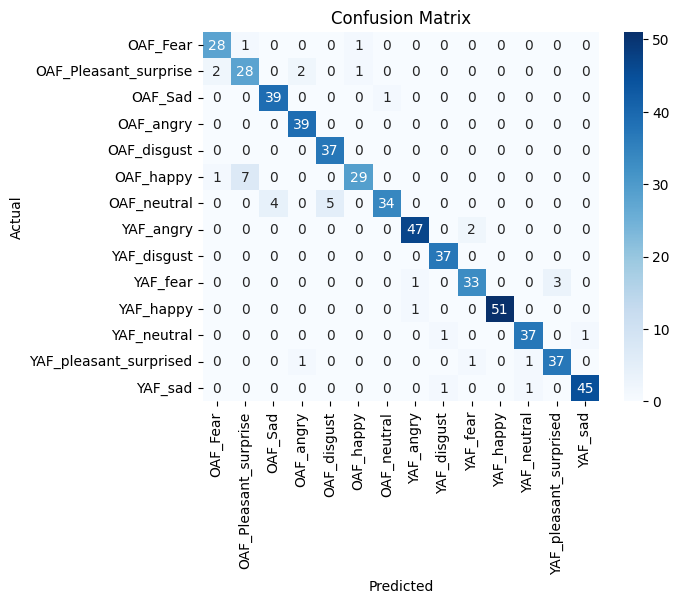

In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


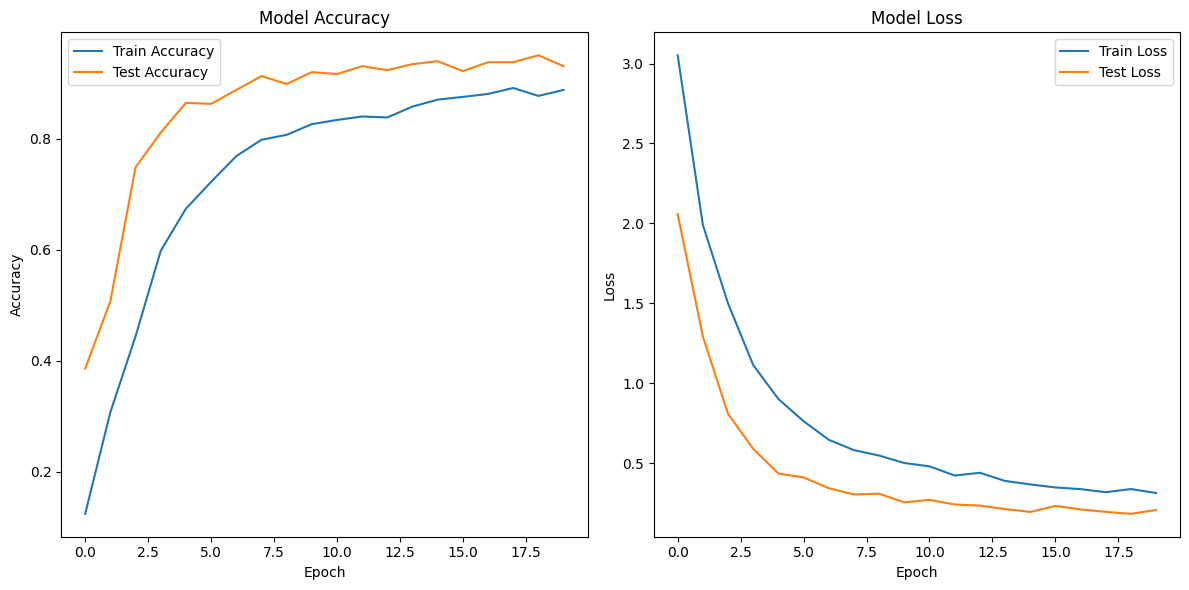

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import ttest_1samp
import numpy as np

test_accuracy = history.history['val_accuracy'][-1]
expected_accuracy = 0.2
accuracies = history.history['val_accuracy']
t_stat, p_value_ttest = ttest_1samp(accuracies, expected_accuracy)

print(f"T-statistic: {t_stat}")
print(f"P-value (T-Test): {p_value_ttest}")

alpha = 0.05
if p_value_ttest < alpha:
    print("Reject the null hypothesis: The model's accuracy is significantly different from random.")
else:
    print("Accept the null hypothesis: The model's accuracy is not significantly different from random.")


T-statistic: 19.603696223647532
P-value (T-Test): 4.580934482309856e-14
Reject the null hypothesis: The model's accuracy is significantly different from random.


In [ ]:
from scipy.stats import norm
import numpy as np

test_accuracy = history.history['val_accuracy'][-1]
expected_accuracy = 0.2
accuracies = history.history['val_accuracy']
std_dev = np.std(accuracies)

z_score = (test_accuracy - expected_accuracy) / (std_dev / np.sqrt(len(accuracies)))
print("Z-score:", z_score)
p_value = norm.sf(abs(z_score)) * 2
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The model's accuracy is significantly different from random.")
else:
    print("Accept the null hypothesis: The model's accuracy is not significantly different from random.")


Z-score: 22.399466517891142
P-value: 3.983191726436953e-111
Reject the null hypothesis: The model's accuracy is significantly different from random.


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Anomalous samples identified: [  7  28  39  51  53  55  68  73  75  78 103 109 115 124 131 134 158 159
 173 175 205 206 209 212 219 277 278 280 286 302 339 344 364 384 413 441
 507 515 530 532 534 538 554]


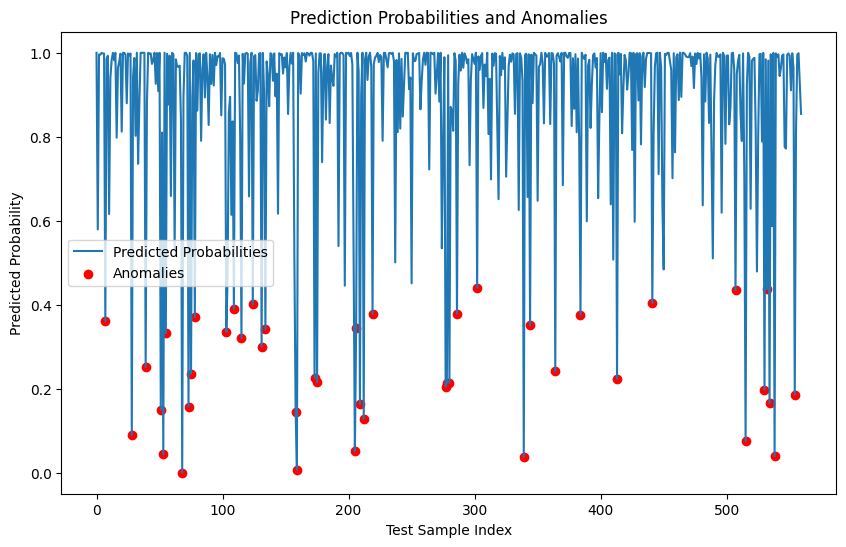

In [ ]:
y_pred_prob = model.predict(X_test)

y_pred_prob = y_pred_prob[np.arange(len(y_pred_prob)), y_test]

mean_prob = np.mean(y_pred_prob)
std_prob = np.std(y_pred_prob)
z_scores_prob = (y_pred_prob - mean_prob) / std_prob

anomalies = np.where(np.abs(z_scores_prob) > 2)[0]

print(f"Anomalous samples identified: {anomalies}")

plt.figure(figsize=(10, 6))
plt.plot(y_pred_prob, label='Predicted Probabilities')
plt.scatter(anomalies, y_pred_prob[anomalies], color='red', label='Anomalies')
plt.title('Prediction Probabilities and Anomalies')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()
